In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__

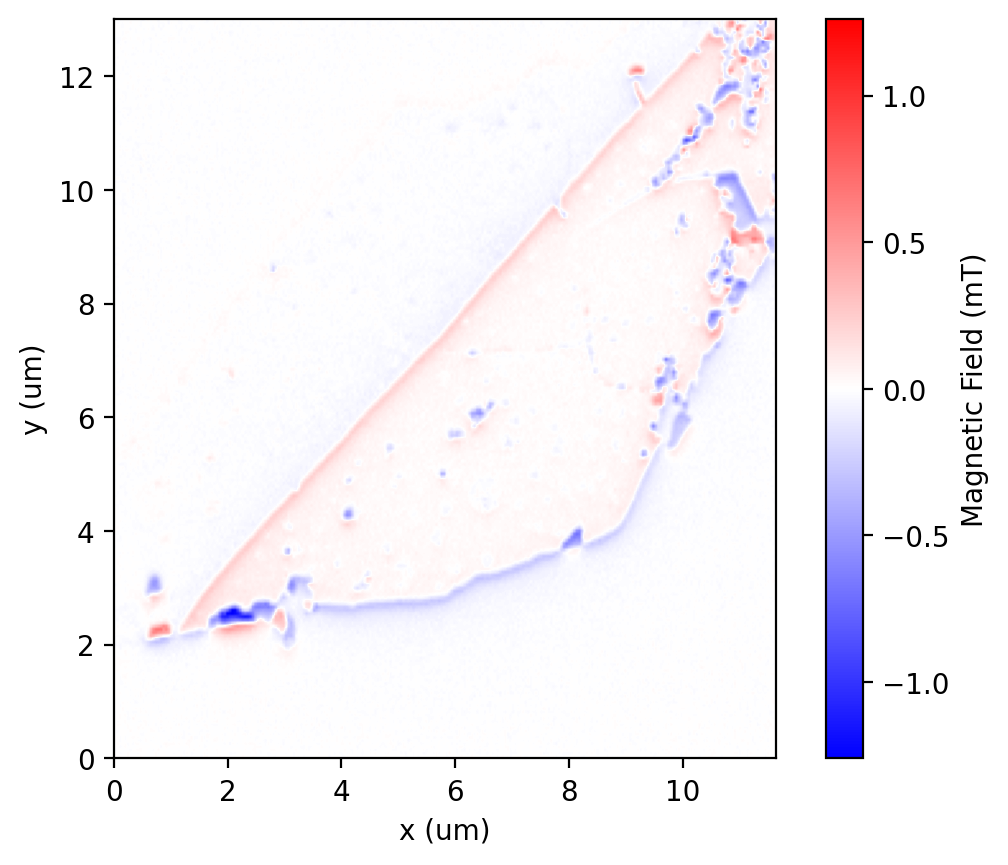

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

dataset = Data()
dataset.load_data(BNV, dx, dy, 0.05, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.plot_target()


In [5]:
# Add filter 
dataset.add_hanning_filter(0.05)
dataset.add_hanning_filter(0.05)

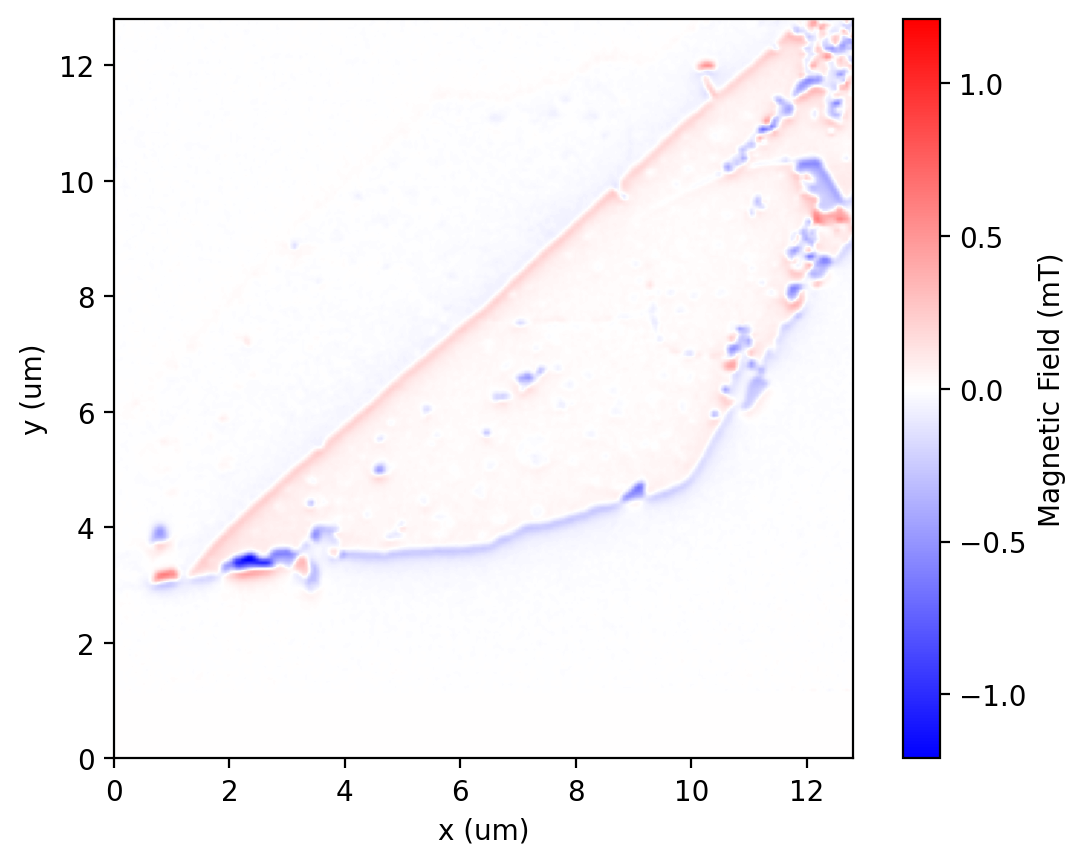

In [6]:
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

In [7]:
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.05
3,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.05
4,crop_data,False,crop_data,crop the data with the given region of interest,"roi = [0,256,0,256,]"
5,pad_data,True,crop_data,Padded the data to a square image with dimensi...,None


# Transfor Bsensor into Bxyz

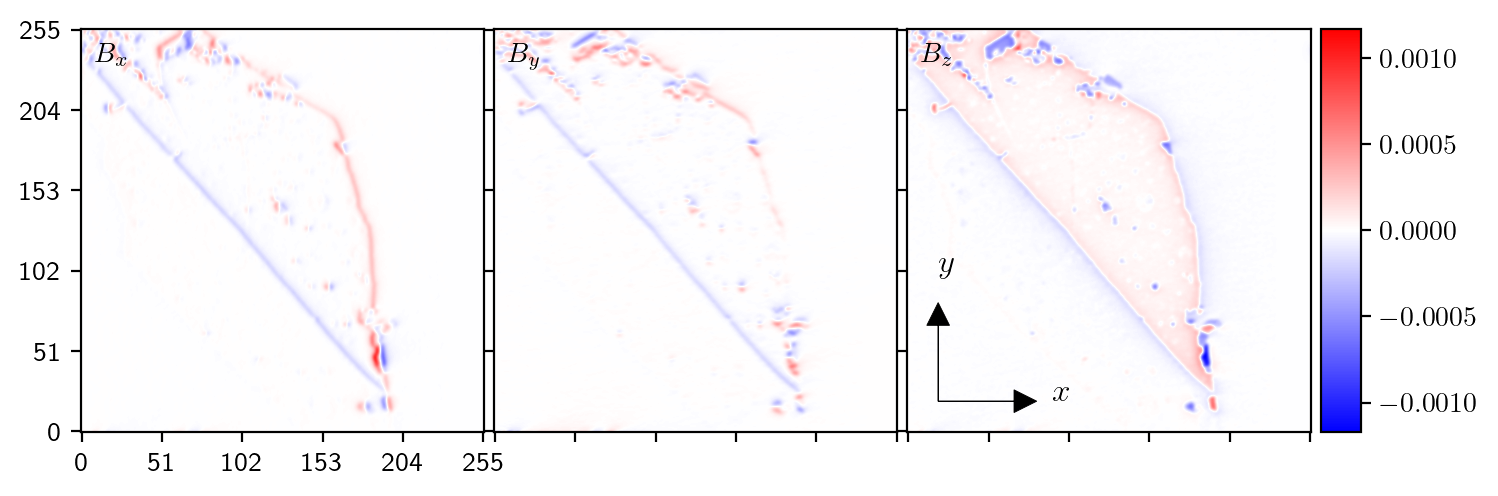

In [8]:
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Reconstruct the out of plane magnetisation using the B sensor

In [9]:
dataset2 = copy.deepcopy(dataset)

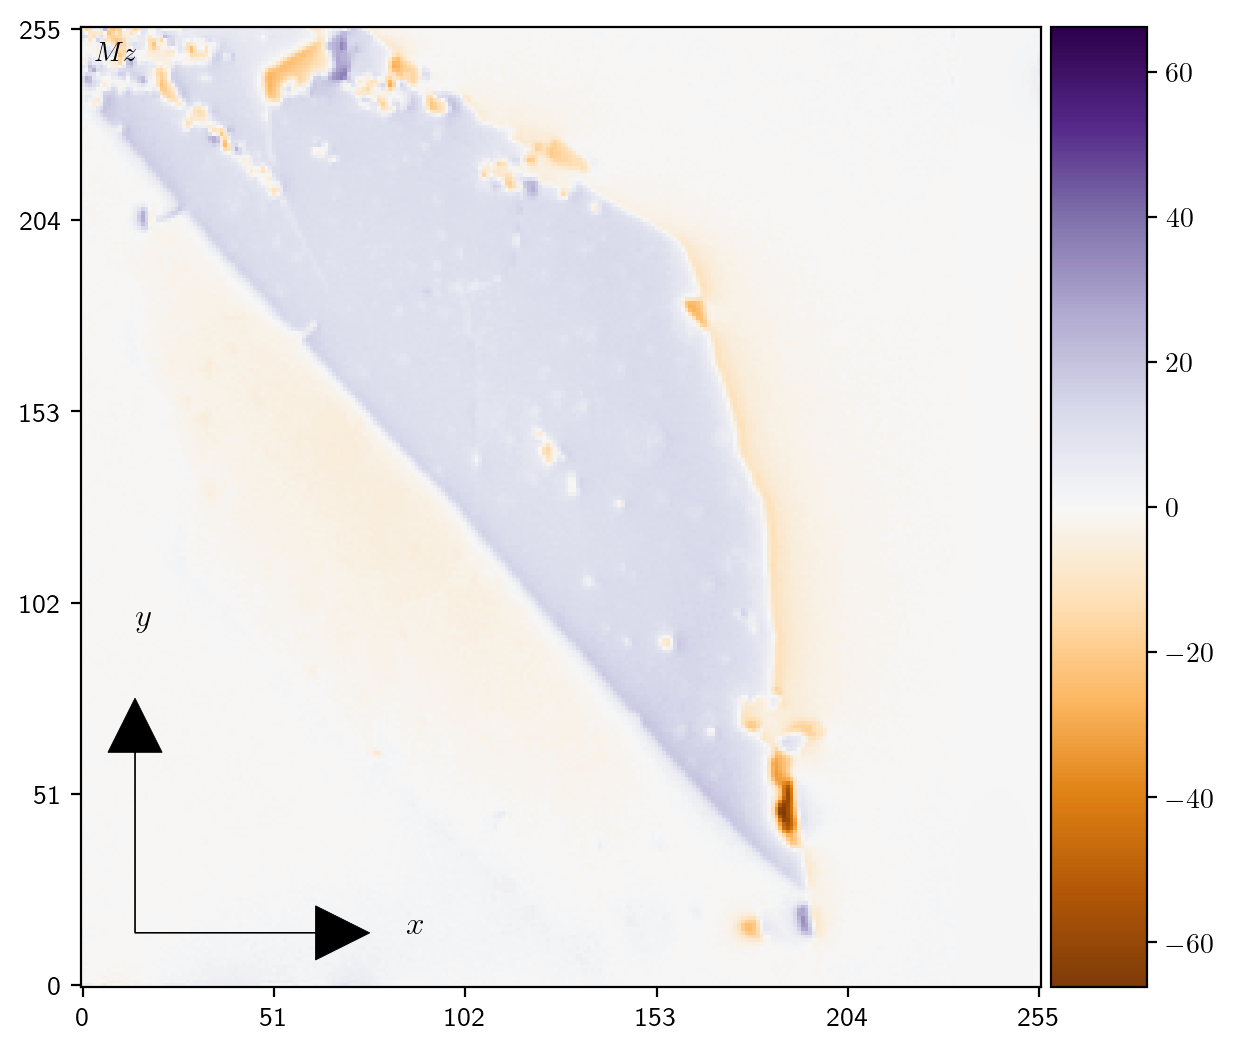

In [10]:
dataset2.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi = 0)
dataset2.transform_data()

plot_n_components(
    -1*dataset2.transformed_target + 2, 
    symmetric=True, 
    labels=[r"$Mz$"], 
    cmap="PuOr")

## Reconstruct using only the Bz magnetic field component

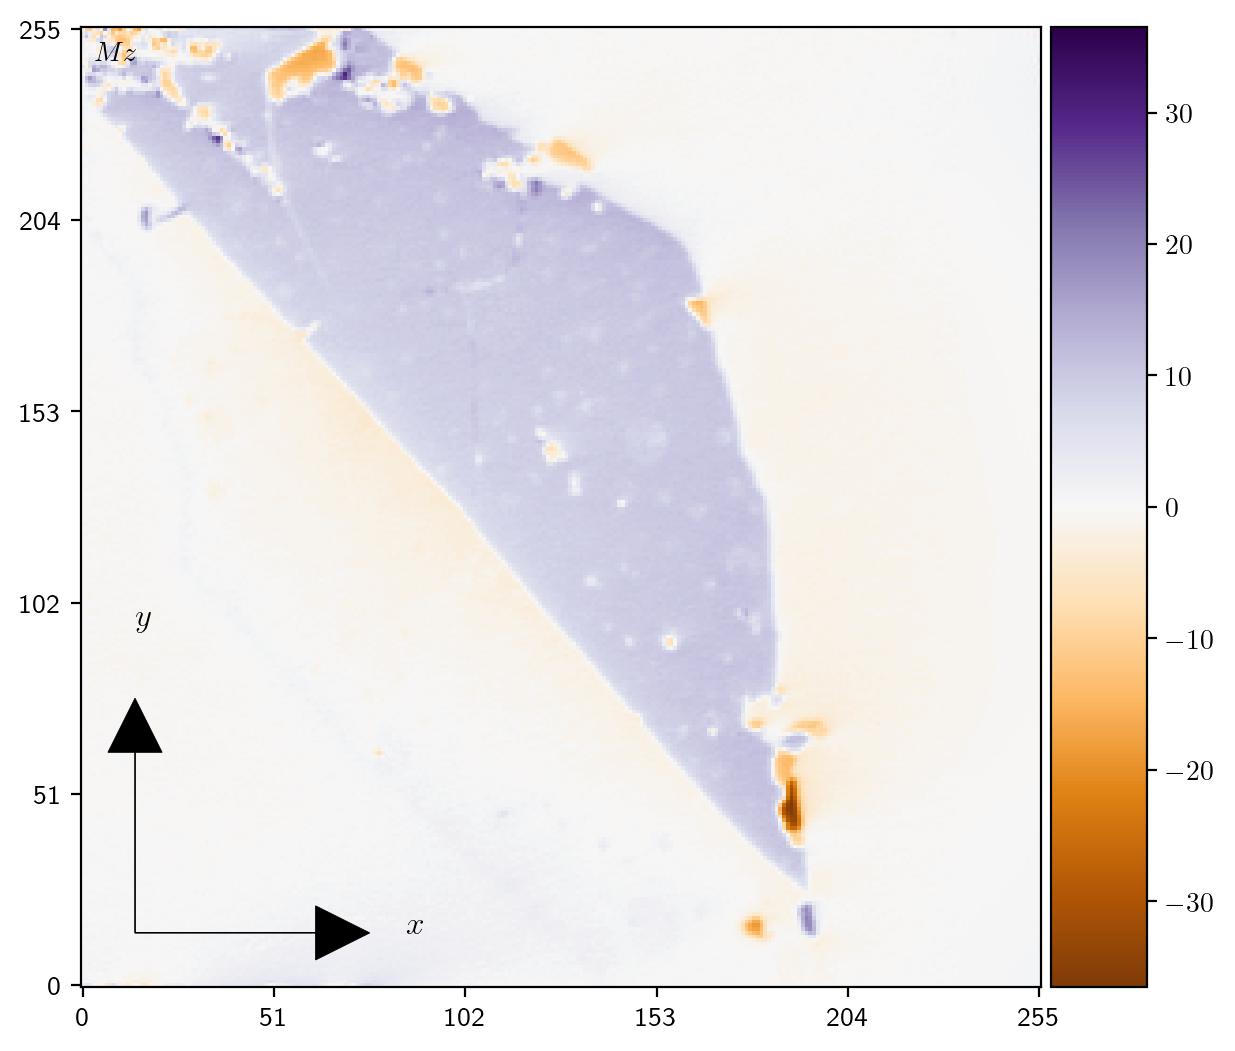

In [11]:
dataset3 = copy.deepcopy(dataset)
dataset3.target = dataset.transformed_target[2,::]
dataset3.define_sensor_angles(0, 0)
dataset3.set_transformer(Bsensor2Mxy, m_theta = 0, m_phi = 0)
dataset3.transform_data()

plot_n_components(
    -1*dataset3.transformed_target + 2, 
    symmetric=True, 
    labels=[r"$Mz$"], 
    cmap="PuOr")

## Now we will try to reconstruct the magnetisation using a neural network.

To begin with let's just test that we can acutally transform a magnetisation to a B-field correctly

In [14]:
from magrec.transformation.Mxy2Bsensor import Mxy2Bsensor

dataset3.target = dataset2.transformed_target
dataset3.define_sensor_angles(0, 0)
dataset3.define_height(0.05)

magClass = Mxy2Bsensor(dataset3, m_theta = 0, m_phi = 0)

btest = magClass.transform(dataset3.target)


<Figure size 640x480 with 0 Axes>

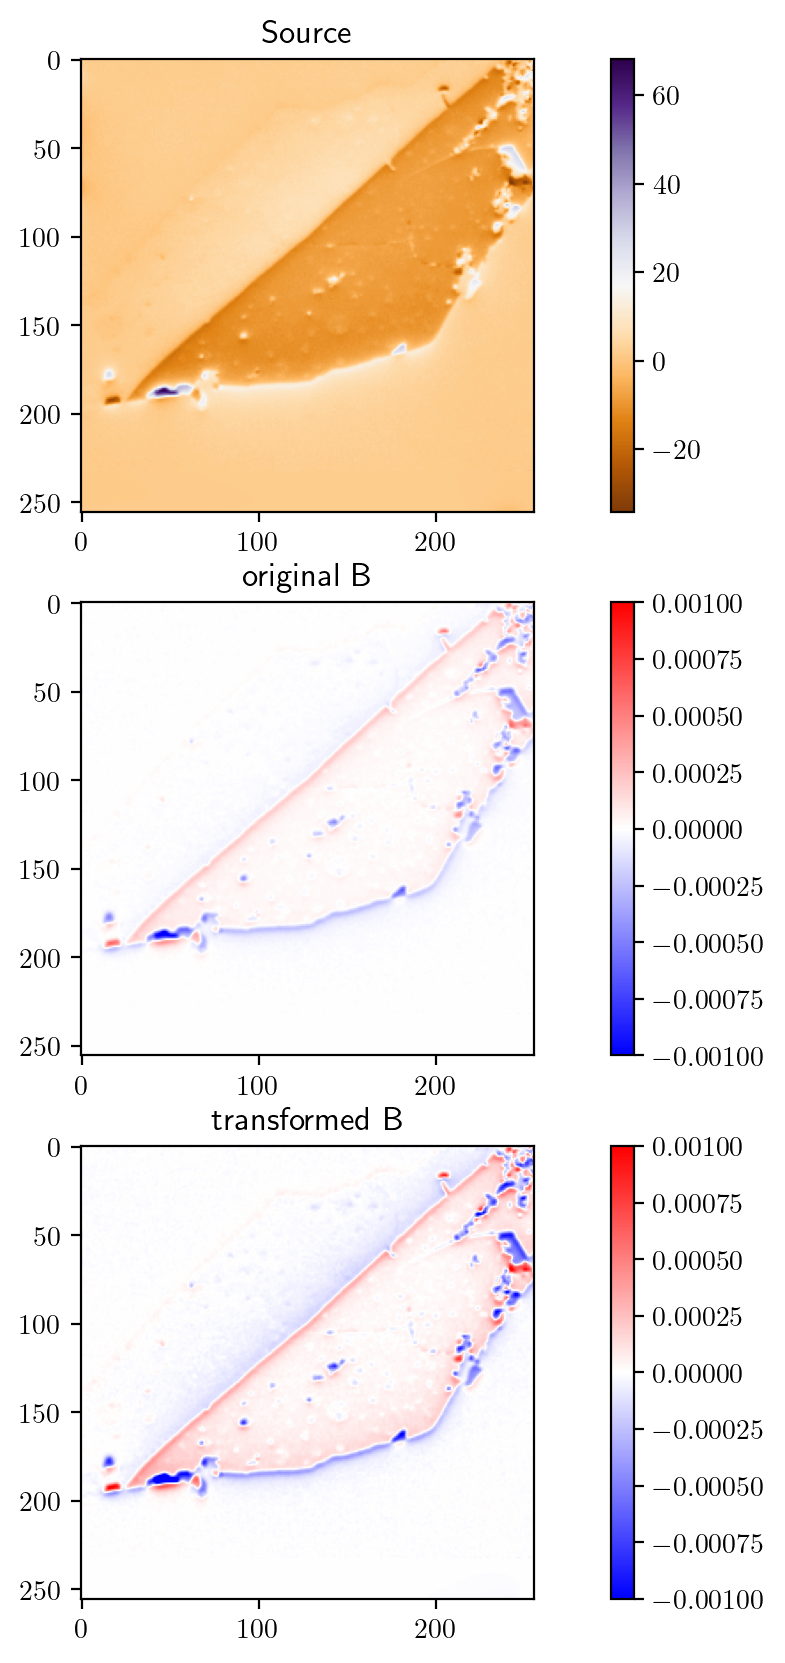

In [15]:
plt.figure()
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.imshow(dataset3.target, cmap="PuOr")
plt.title("Source")
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(dataset2.target, cmap="bwr", vmin=-0.001, vmax=0.001)
plt.title("original B")
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(btest, cmap="bwr", vmin=-0.001, vmax=0.001)
plt.title("transformed B")
plt.colorbar()

In [17]:
from magrec.method.CNN import CNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

dataset4 = copy.deepcopy(dataset)
dataset4.target = dataset4.target

Model = UniformMagnetisation(dataset4, "MSE", m_theta = 0, m_phi = 0)
FittingMethod = CNN(Model, dataset4)
FittingMethod.prepare_fit()

Number of sources: 1
Number of targets: 1


In [28]:
Model.transform(dataset3.target[np.newaxis, np.newaxis])

tensor([[[[ 1.2555e-05, -3.5077e-06, -5.3743e-06,  ...,  2.0766e-04,
            7.7469e-05, -1.1500e-04],
          [ 1.3745e-05, -7.9909e-06, -9.7164e-06,  ...,  1.4063e-04,
           -3.8931e-05, -2.5836e-04],
          [ 1.9707e-05,  2.2173e-06, -6.6414e-06,  ..., -1.7602e-04,
           -1.9563e-04, -1.9341e-04],
          ...,
          [ 4.6955e-10,  4.6629e-10,  4.6898e-10,  ...,  4.7465e-10,
            4.7454e-10,  4.6682e-10],
          [ 4.8198e-10,  4.6190e-10,  4.5816e-10,  ...,  4.8674e-10,
            4.7714e-10,  4.7721e-10],
          [ 4.5256e-10,  4.4995e-10,  4.3901e-10,  ...,  4.7410e-10,
            4.4709e-10,  4.3593e-10]]]])

In [22]:
FittingMethod.fit(n_epochs=100)

epoch     1 | loss on last mini-batch:  3.95e-09
epoch    11 | loss on last mini-batch:  3.95e-09
epoch    21 | loss on last mini-batch:  3.95e-09
epoch    31 | loss on last mini-batch:  3.95e-09
epoch    41 | loss on last mini-batch:  3.95e-09
epoch    51 | loss on last mini-batch:  3.95e-09
epoch    61 | loss on last mini-batch:  3.95e-09
epoch    71 | loss on last mini-batch:  3.95e-09
epoch    81 | loss on last mini-batch:  3.95e-09
epoch    91 | loss on last mini-batch:  3.95e-09


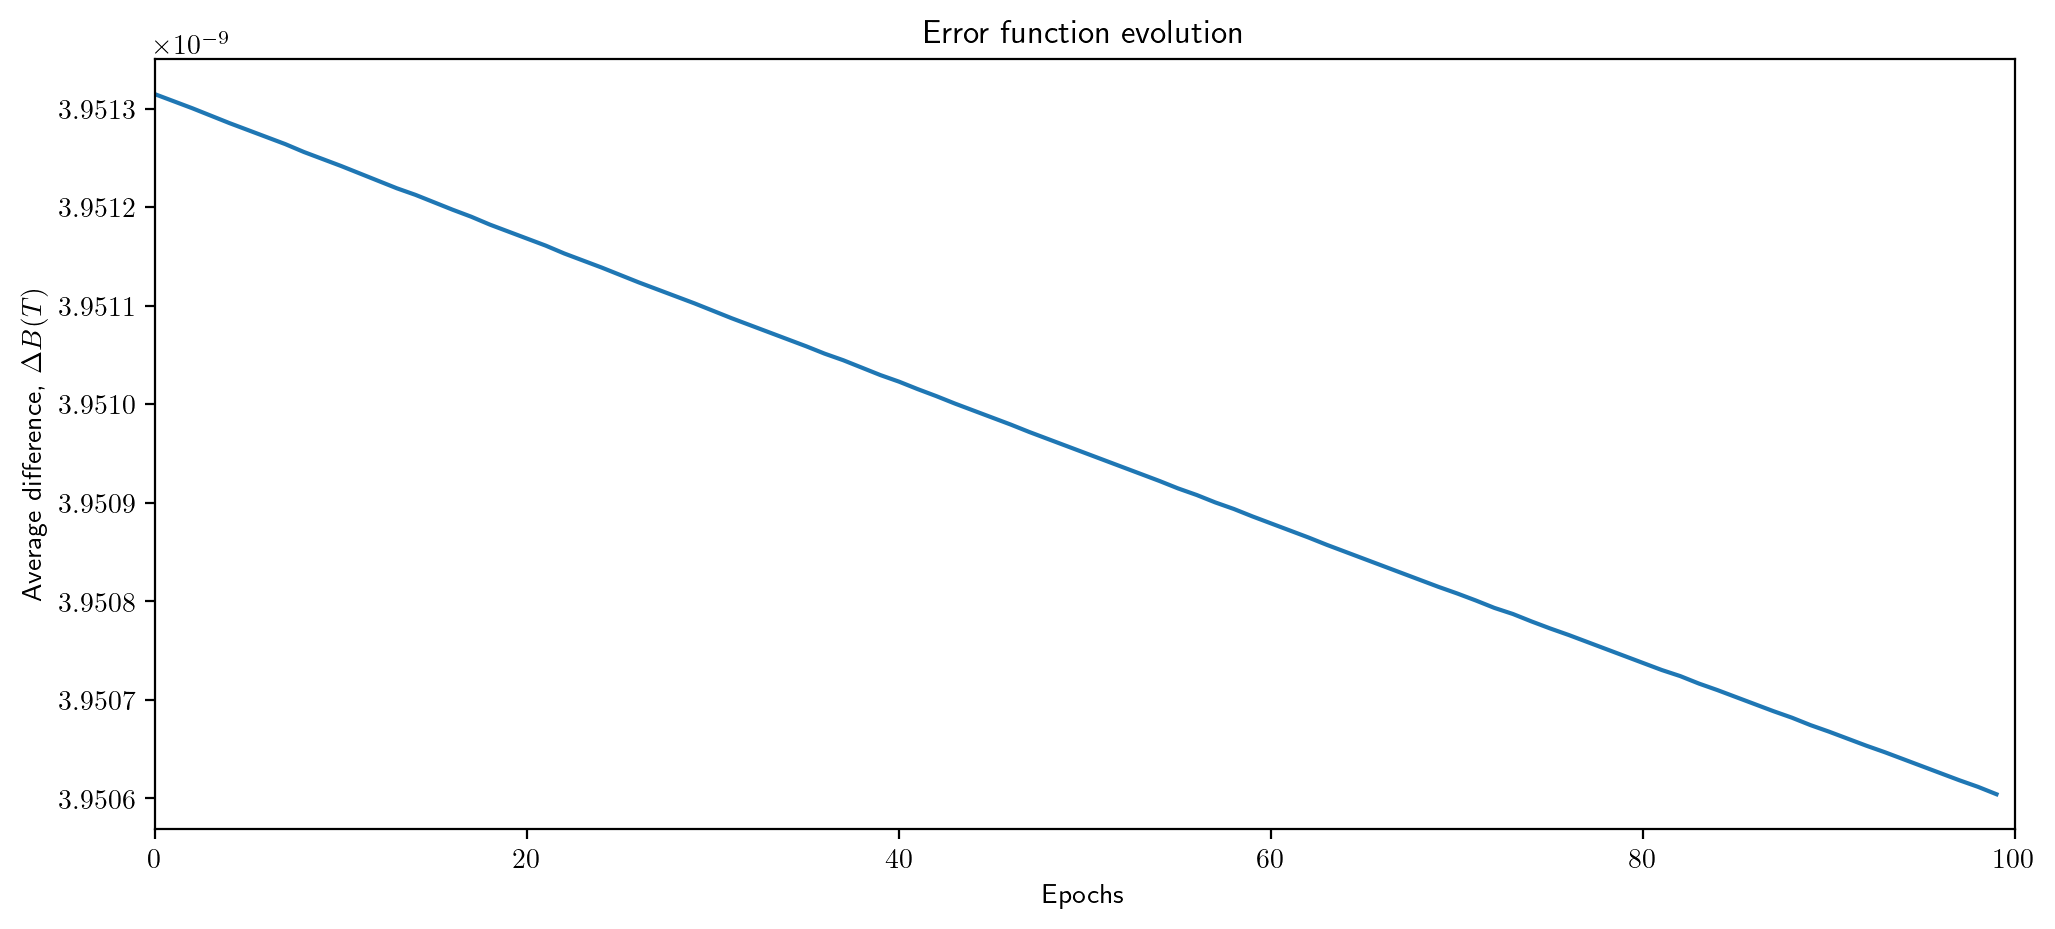

In [23]:
FittingMethod.plot_loss()

<Figure size 640x480 with 0 Axes>

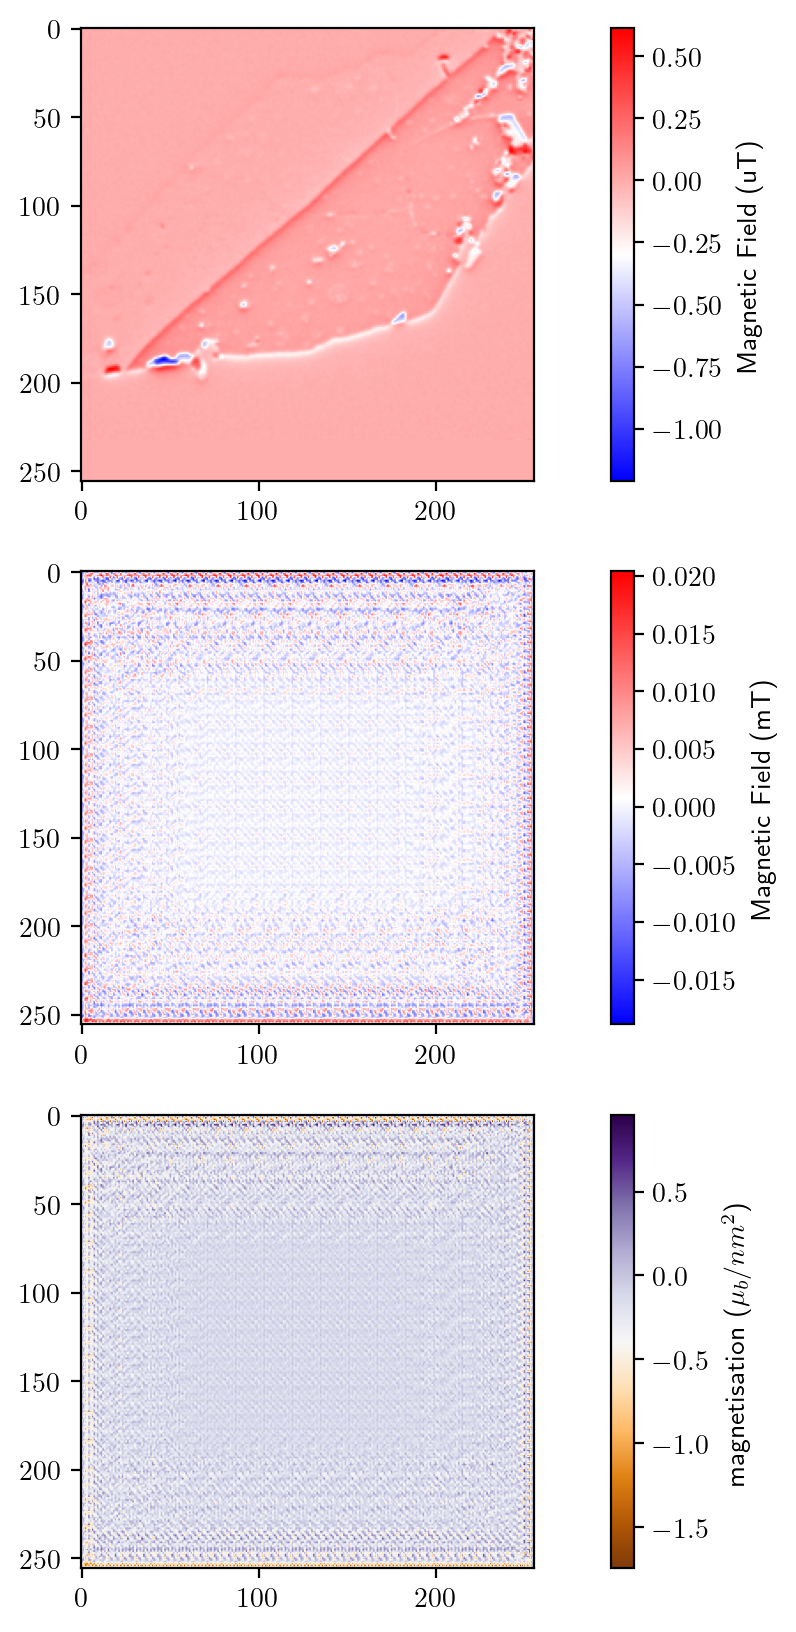

In [25]:
plt.figure()
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.imshow(dataset4.target*1e3, cmap="bwr")
cb = plt.colorbar()
cb.set_label("Magnetic Field (uT)")

plt.subplot(3,1,2)
plt.imshow(FittingMethod.final_b*1e3, cmap="bwr")
cb = plt.colorbar()
cb.set_label("Magnetic Field (mT)")

plt.subplot(3,1,3)
plt.imshow(FittingMethod.final_output, cmap="PuOr")
cb = plt.colorbar()

cb.set_label("magnetisation ($\mu_b/nm^2$)")